##Celda 1: Instalación de Librerías

In [1]:
!pip install umap-learn gdown h5py

## Celda 2: Importaciones

In [2]:
import gdown
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

print("Librerías importadas correctamente.")

Librerías importadas correctamente.


##Celda 3: Descarga del Dataset USPS desde Google Drive

In [3]:
file_id = '1vi574FU1on9JiyD3fC59ktj1AfnlH3bL'
output_file = 'USPS.h5'
gdown.download(f'https://drive.google.com/uc?id={file_id}', output_file, quiet=False)

print(f"\nArchivo '{output_file}' descargado exitosamente.")

Downloading...
From: https://drive.google.com/uc?id=1vi574FU1on9JiyD3fC59ktj1AfnlH3bL
To: /content/USPS.h5
100%|██████████| 2.91M/2.91M [00:00<00:00, 49.9MB/s]


Archivo 'USPS.h5' descargado exitosamente.


##Celda 4: Carga y Preparación de los Datos desde el archivo .h5

In [5]:
with h5py.File(output_file, 'r') as hf:
    # --- PASO DE DEPURACIÓN: Imprimir la estructura para ver las claves correctas ---
    print("Inspeccionando la estructura del archivo H5:")
    if 'train' in hf:
        print("Claves disponibles en el grupo 'train':", list(hf['train'].keys()))
    if 'test' in hf:
        print("Claves disponibles en el grupo 'test':", list(hf['test'].keys()))
    print("-" * 30)

    # --- CÓDIGO CORREGIDO ---
    # El error indica que la clave 'labels' no existe. La clave correcta en este archivo es 'target'.

    # Cargar datos de entrenamiento
    X_train = hf.get('train').get('data')[:]
    y_train = hf.get('train').get('target')[:] # CORRECCIÓN: Usar 'target' en lugar de 'labels'
    # Cargar datos de prueba
    X_test = hf.get('test').get('data')[:]
    y_test = hf.get('test').get('target')[:] # CORRECCIÓN: Usar 'target' en lugar de 'labels'

# Combinar los conjuntos de entrenamiento y prueba para la visualización
X = np.vstack((X_train, X_test))
y = np.hstack((y_train, y_test))

# Las imágenes de USPS son 16x16.
# Los datos están aplanados (16*16=256).
# Creamos una variable 'images' con la forma original para la visualización.
images = X.reshape(-1, 16, 16)

print(f"Dataset cargado y combinado exitosamente.")
print(f"Forma de los datos aplanados (X): {X.shape}")
print(f"Forma de las etiquetas (y): {y.shape}")
print(f"Forma de las imágenes para graficar: {images.shape}")

# Escalar los datos es crucial para PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Inspeccionando la estructura del archivo H5:
Claves disponibles en el grupo 'train': ['data', 'target']
Claves disponibles en el grupo 'test': ['data', 'target']
------------------------------
Dataset cargado y combinado exitosamente.
Forma de los datos aplanados (X): (9298, 256)
Forma de las etiquetas (y): (9298,)
Forma de las imágenes para graficar: (9298, 16, 16)


##Celda 5: Aplicar PCA y UMAP

In [6]:
# 1. Reducción con PCA
print("Aplicando PCA...")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 2. Reducción con UMAP
print("Aplicando UMAP...")
# Usamos random_state para que los resultados sean reproducibles
umap_reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = umap_reducer.fit_transform(X_scaled)

print("Reducción de dimensionalidad completada.")
print(f"Forma de los datos tras PCA: {X_pca.shape}")
print(f"Forma de los datos tras UMAP: {X_umap.shape}")

Aplicando PCA...
Aplicando UMAP...


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Reducción de dimensionalidad completada.
Forma de los datos tras PCA: (9298, 2)
Forma de los datos tras UMAP: (9298, 2)


##Celda 6: Función Auxiliar para Graficar con Imágenes

In [8]:
def plot_projection_with_images(X_proj, images, y, title):
    """
    Función para graficar una proyección 2D (PCA o UMAP) con colores por clase
    y superponiendo algunas imágenes de ejemplo, evitando el solapamiento.
    """
    fig, ax = plt.subplots(figsize=(14, 12))

    # Graficamos la proyección como un scatter plot
    scatter = ax.scatter(X_proj[:, 0], X_proj[:, 1], c=y, cmap='jet', s=15, alpha=0.6)

    # Creamos una leyenda para los colores de los dígitos
    legend1 = ax.legend(handles=scatter.legend_elements()[0], labels=list(range(10)), title="Dígitos")
    ax.add_artist(legend1)

    # Inicializamos un array 2D para almacenar las coordenadas de las imágenes ya mostradas
    shown_images_coords = np.array([[-1e9, -1e9]])

    # Decidimos cuántas imágenes mostrar para no saturar el gráfico
    num_images_to_show = 70
    indices_to_show = np.random.choice(len(y), num_images_to_show, replace=False)

    for i in indices_to_show:
        # Calculamos la distancia euclidiana al cuadrado desde el punto actual
        # a todos los puntos de las imágenes ya mostradas
        dist = np.sum((X_proj[i] - shown_images_coords) ** 2, axis=1)

        # Si está muy cerca de una imagen ya mostrada, la saltamos
        # El umbral puede necesitar ajuste dependiendo de la escala de la proyección
        if np.min(dist) < 0.8: # Umbral ajustado
            continue

        # Añadimos el punto a nuestra lista y mostramos la imagen
        shown_images_coords = np.r_[shown_images_coords, [X_proj[i]]]
        imagebox = OffsetImage(images[i], cmap='gray', zoom=1.5)
        ab = AnnotationBbox(imagebox, X_proj[i], frameon=True, pad=0.2, bboxprops=dict(edgecolor='white'))
        ax.add_artist(ab)

    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Componente 1")
    ax.set_ylabel("Componente 2")
    plt.show()

##Celda 7: Generación de Gráficos Principales

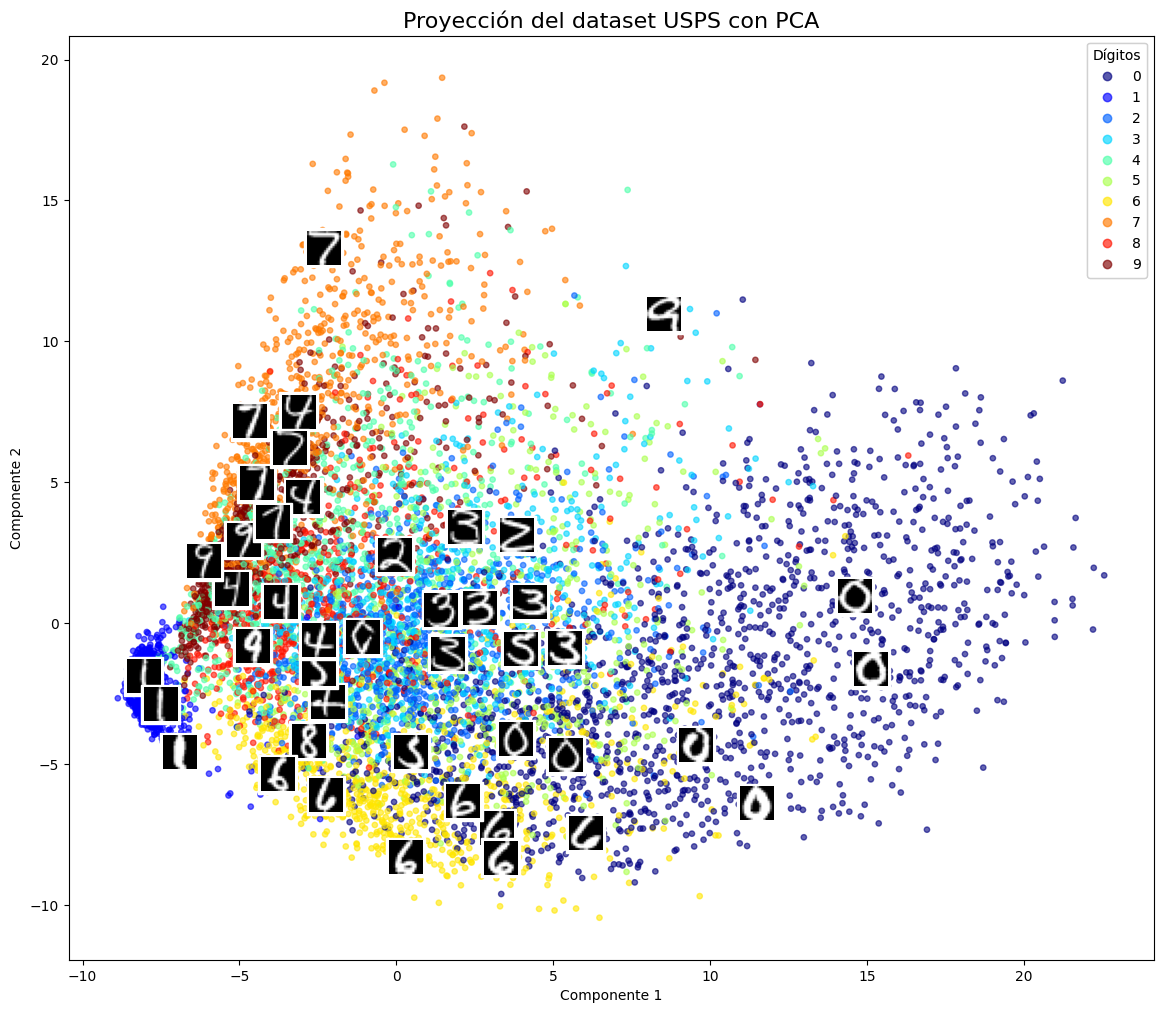

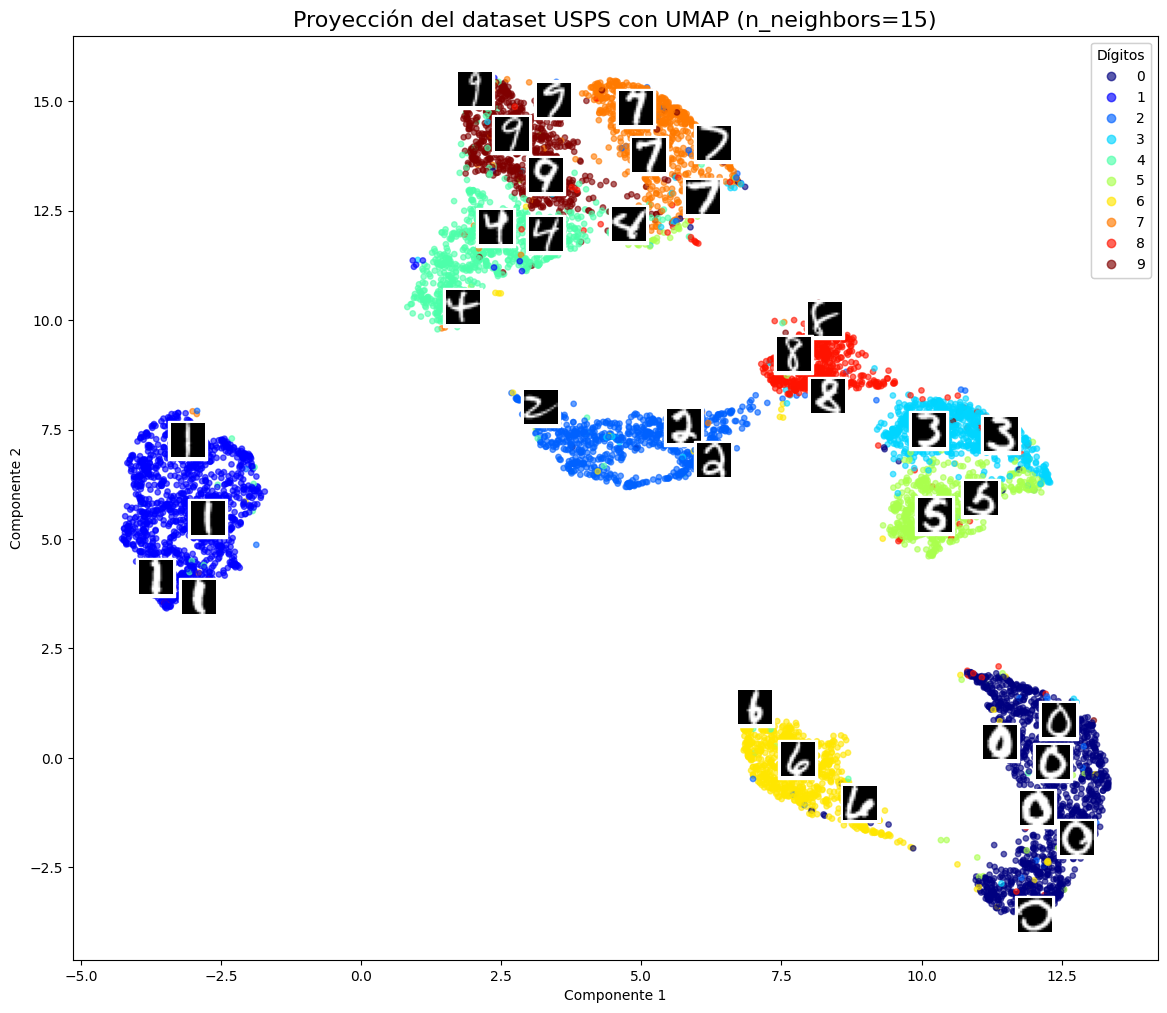

In [9]:
# Graficar la proyección de PCA
plot_projection_with_images(X_pca, images, y, "Proyección del dataset USPS con PCA")

# Graficar la proyección de UMAP
plot_projection_with_images(X_umap, images, y, "Proyección del dataset USPS con UMAP (n_neighbors=15)")

##Celda 8: Exploración del Parámetro n_neighbors en UMAP

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


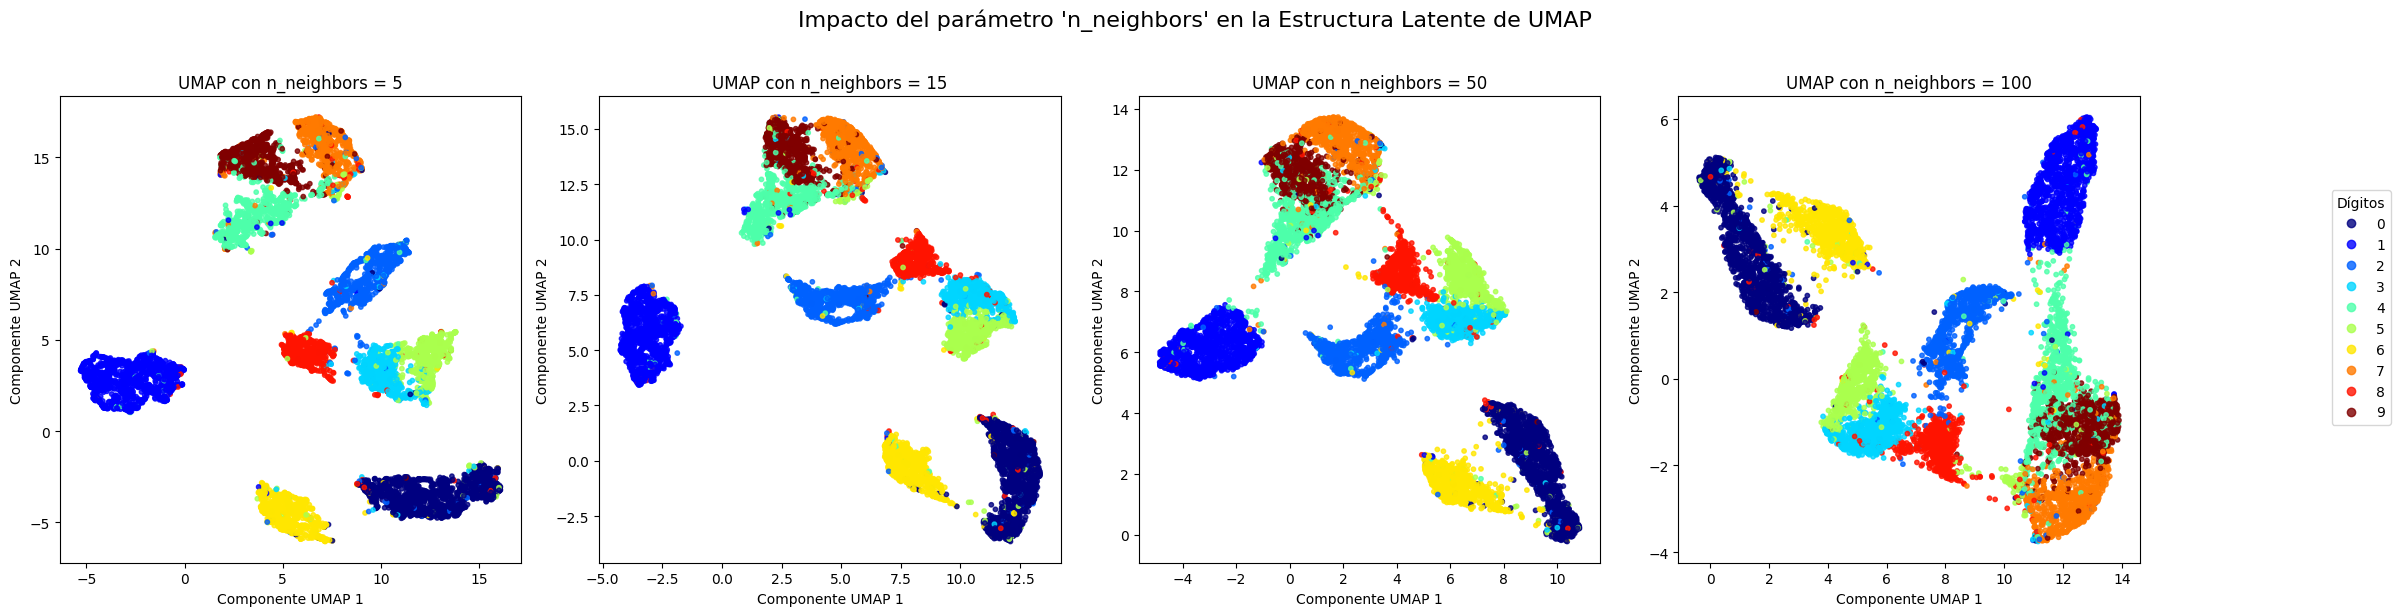

In [10]:
# Lista de valores para n_neighbors a explorar
neighbor_values = [5, 15, 50, 100]

fig, axes = plt.subplots(1, 4, figsize=(24, 6))

for i, n in enumerate(neighbor_values):
    # Aplicamos UMAP con el valor actual de n_neighbors
    reducer = umap.UMAP(n_components=2, n_neighbors=n, random_state=42)
    X_umap_variant = reducer.fit_transform(X_scaled)

    # Graficamos el resultado
    ax = axes[i]
    scatter = ax.scatter(X_umap_variant[:, 0], X_umap_variant[:, 1], c=y, cmap='jet', s=10, alpha=0.8)
    ax.set_title(f"UMAP con n_neighbors = {n}")
    ax.set_xlabel("Componente UMAP 1")
    ax.set_ylabel("Componente UMAP 2")

# Añadimos una leyenda general
fig.legend(handles=scatter.legend_elements()[0], labels=list(range(10)), title="Dígitos", loc='center right')
plt.suptitle("Impacto del parámetro 'n_neighbors' en la Estructura Latente de UMAP", fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

##Celda 9: Conclusiones

### Análisis de los Resultados de Reducción de Dimensionalidad



### 1. Análisis de las Diferencias entre PCA y UMAP

Al observar los gráficos generados, las diferencias fundamentales entre las proyecciones de PCA y UMAP son evidentes y significativas:

1.  **Separación de Clases:**
    *   **UMAP** demuestra una capacidad muy superior para separar los clústeres correspondientes a cada dígito. Los grupos de colores están bien definidos, son densos y tienen una separación clara entre ellos.
    *   **PCA**, en cambio, produce una proyección donde las clases se superponen considerablemente. Dígitos como el 4, 7 y 9 aparecen muy mezclados, lo que dificulta su distinción visual. Esto evidencia que UMAP es mucho más efectivo para preservar la estructura local que permite la clasificación.

2.  **Estructura Preservada:**
    *   **PCA** es un método lineal que busca maximizar la varianza global. El resultado es una "nube" de puntos donde se captura la dispersión general de los datos, pero se pierden las relaciones topológicas más finas (la estructura de "variedad" o *manifold*).
    *   **UMAP** es un algoritmo de *manifold learning* no lineal. Su objetivo es preservar la estructura topológica de los datos, lo que le permite "desenredar" la variedad en la que viven los datos y revelar clústeres y relaciones que son invisibles para PCA.

3.  **Interpretación de los Ejes:**
    *   Los ejes en **PCA** son los "Componentes Principales" y tienen una interpretación matemática clara: son las direcciones ortogonales de máxima varianza en los datos.
    *   Los ejes en **UMAP** no tienen una interpretación directa y aislada. Son simplemente las coordenadas 2D que mejor representan la estructura topológica de alta dimensión, priorizando la conservación de las relaciones de vecindad.

---

### 2. Impacto del Parámetro `n_neighbors` en UMAP

El hiperparámetro `n_neighbors` es crucial en UMAP, ya que define el tamaño del vecindario local que el algoritmo considera para cada punto. Este parámetro controla el equilibrio entre preservar la **estructura local** (detalles finos) y la **estructura global** (el panorama general).

*   **`n_neighbors=5` (Valor bajo):**
    *   Al usar un número bajo de vecinos, UMAP se enfoca intensamente en las relaciones más inmediatas de cada punto.
    *   **Efecto:** La proyección resultante tiende a fragmentar los datos en muchos clústeres pequeños y muy densos. Se prioriza la preservación de la estructura local más fina a costa de perder la relación global entre los clústeres.

*   **`n_neighbors=15` (Valor de equilibrio):**
    *   Este valor (el predeterminado en la librería) suele ofrecer un excelente balance.
    *   **Efecto:** Se obtiene una buena separación de los clústeres principales (cada dígito forma un grupo claro) sin perder la conexión entre ellos. Es un buen punto de partida que revela tanto la estructura local como la global de manera equilibrada.

*   **`n_neighbors=50` y `100` (Valores altos):**
    *   Al considerar un vecindario mucho más grande, UMAP se ve forzado a enfocarse en la estructura a gran escala.
    *   **Efecto:** La proyección tiende a unir más los clústeres, mostrando cómo se relacionan entre sí en el "mapa" general. Las separaciones entre clústeres se vuelven menos marcadas y la forma global de la proyección se vuelve más conexa. Se prioriza el "panorama general" sobre los detalles locales.

### Conclusión General

En conclusión, **UMAP** demuestra ser una herramienta significativamente más poderosa que PCA para la visualización y preservación de la estructura en el dataset USPS. La elección del hiperparámetro `n_neighbors` es fundamental y debe ajustarse según el objetivo del análisis: valores bajos para investigar sub-estructuras y detalles finos, y valores altos para comprender la disposición global del espacio latente.